# Model 1_2
## Dataset: Gym

## Programmer: Giovanni Vecchione
## Date: 4/17/24
## Subject: Machine Learning 2 - Project 6
Use Reinforced Learning (RL) to build the project. Submit your project as Jupyter notebook.

## Policy:
Deep Q-Learning Policy

## Status:
Incomplete - Needs further testing.

In [41]:
import matplotlib as mtp
import torch
import numpy as np
import gym
import random
import tensorflow as tf
from tensorflow import keras 
import matplotlib.animation
import matplotlib.pyplot as plt

create the images/rl folder (if it doesn't already exist), and define the save_fig() function which is used through this notebook to save the figures in high-res for the book:

In [42]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [43]:
#Checks if GPU is being used
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0)) 
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("GPU not available, using CPU.")

#Using GPU: NVIDIA GeForce GTX 1660 SUPER - Successful
#NOTE: This took some time to set up by installing and pathing the cuda toolkit v.12.4 and the right supplemental packages. This drastically improved
#training time

Using GPU: NVIDIA GeForce GTX 1660 SUPER


In [44]:
#Creates the environment to simulate the world needed. This includes all the necessary physics, rules, goals, etc.
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [45]:
# extra code - shows the first few environments
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'BipedalWalker-v3', '...']

In [46]:
# extra code - shows the specification for the CartPole-v1 environment
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1)

In [47]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [48]:
info

{}

In [49]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

The env variable now acts as the way you'll interact with the environment. You'll use functions provided by it to:
env.reset(): Get the initial state of the environment.
env.step(action): Take an action and see the resulting new state, reward, and whether the episode is finished.
env.render(): (Optional) Visualize the environment.

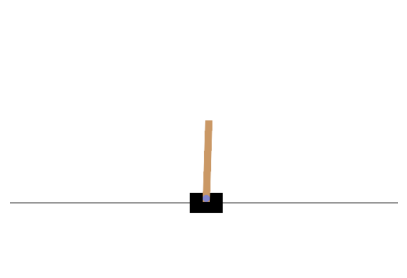

In [50]:
# extra code - creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

In [51]:
print(env.observation_space)  # What the agent observes
print(env.action_space)       # Actions the agent can take

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Discrete(2)


Your agent will need to select an action from an "action space" (the set of possible actions)
Accelerate seems to mean moving right towards (1).

# Using Q-Learning

### *Key Points*
* Q-value Represents the expected future reward the agent can get by taking a particular action in a given state.

## *Setting up a Q-table*
In CartPole, the agent's observations (position, velocity, angle, etc.) are continuous values. To use Q-learning effectively, we'll need to discretize these observations into a finite set of states. Use techniques like binning or clustering to do this.

1. Understanding Discrete States

    * In CartPole, the agent's observations (position, velocity, angle, etc.) are continuous values. To use Q-learning effectively, we'll need to discretize these observations into a finite set of states. You might use techniques like binning or clustering to do this.

2. Initializing the Q-table
    * We'll use a simple data structure like a NumPy array or a Python dictionary to represent our Q-table

3. Interpretation

    * Rows: Each row in the Q-table corresponds to a specific discrete state of the environment.
    * Columns: Each column represents a possible action the agent can take (in CartPole, move left or move right).
    * Values: The value inside a cell Q_table[state, action] represents the estimated future reward the agent expects to get if it takes the action in the state and follows its optimal policy from there onwards.


In [52]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

## Creating A Neural Network

In theory, we need a neural net that takes a state-action pair as input, and outputs an approximate Q-value. However, in practice it's much more efficient to use a neural net that takes only a state as input, and outputs one approximate Q-value for each possible action.

In [53]:
tf.random.set_seed(42)  # extra code - ensures reproducibility on the CPU
input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu", kernel_regularizer=keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation="elu"),
    tf.keras.layers.Dense(16, activation="elu"),
    tf.keras.layers.Dropout(rate=0.20),
    tf.keras.layers.Dense(n_outputs)
])

c:\Users\GioDude\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



## *Agent Initialization and The Learning Loop*
Create an agent that will interact with the environment to learn the optimal balancing policy.

### *The Agent's Components:*

* The Q-table:  This data structure embodies the core knowledge of the agent. It stores the agent's understanding of the best actions to take in different states.

* Policy: As the Q-table is updated, the agent implicitly develops a policy. This policy is essentially the way it decides which action to take based on its current state. In Q-learning, the policy is often an epsilon-greedy policy, striking a balance between exploring new actions and exploiting its current knowledge.

* Learning Algorithm: The Q-learning update rule itself is the core mechanism by which the agent learns. This algorithm updates the Q-table based on the agent's experiences, progressively improving the agent's knowledge of good and bad actions.

### So, where's the agent?

The agent in Q-learning is an emergent entity. It's not explicitly programmed, but rather emerges from the combination of the Q-table, its implicit policy, and the learning algorithm.

* Discount factor (gamma): Determines how much we value future rewards compared to immediate rewards.
* Learning rate (alpha): Controls how much we update our Q-values with each new experience.

In [54]:
# Hyperparameters
alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90  # discount factor
state = 0  # initial state

In [55]:
Q_values = np.full((3, 3), -np.inf)  # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [56]:
# ε-greedy policy (i.e., we will choose a random action with probability ε)
# To ensure that the agent explores the environment, we choose a random action with probability epsilon
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

In [57]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [58]:
from collections import deque
#Instead of training the DQN based only on the latest experiences, we will store all experiences in a replay buffer (or replay memory), 
#and we will sample a random training batch from it at each training iteration.
replay_buffer = deque(maxlen=2000)

In [59]:
#small function to sample a random batch of experiences from the replay buffer
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ] 
#It will return six NumPy arrays corresponding to the six experience elements
# [states, actions, rewards, next_states, dones, truncateds]

In [60]:
#Function will play a single step using the ε-greedy policy, then store the resulting experience in the replay buffer
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [61]:
# extra code - for reproducibility, and to generate the next figure
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

In [62]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

#Training Function
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

### Here's what's happening in this code above:

1. *Initalize Variables:* First we define some hyperparameters, and we create the optimizer and the loss function.

2. *Create the training_step() function:* It starts by sampling a batch of experiences, then it uses the DQN to predict the Q-value for each possible action in each experience's next state. Since we assume that the agent will be playing optimally, we only keep the maximum Q-value for each next state. Next, we use Equation 18-7 to compute the target Q-value for each experience's state-action pair.

3. We want to use the DQN to compute the Q-value for each experienced state-action pair, but the DQN will also output the Q-values for the other possible actions, not just for the action that was actually chosen by the agent. So, we need to mask out all the Q-values we do not need. The tf.one_hot() function makes it possible to convert an array of action indices into such a mask. For example, if the first three experiences contain actions 1, 1, 0, respectively, then the mask will start with [[0, 1], [0, 1], [1, 0],...]. We can then multiply the DQN's output with this mask, and this will zero out all the Q-values we do not want. We then sum over axis 1 to get rid of all the zeros, keeping only the Q-values of the experienced state-action pairs. This gives us the Q_values tensor, containing one predicted Q-value for each experience in the batch.

4. *Compute the loss:* The mean squared error between the target and predicted Q-values for the experienced state-action pairs.

5. *Gradient Descent Step:* Finally, we perform a gradient descent step to minimize the loss with regard to the model's trainable variables.

In [63]:
for episode in range(600):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    if episode > 50:
        training_step(batch_size)

# extra code - displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # extra code - restores the best model weights

c:\Users\GioDude\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 17, Steps: 18, eps: 0.968

Episode: 600, Steps: 200, eps: 0.010

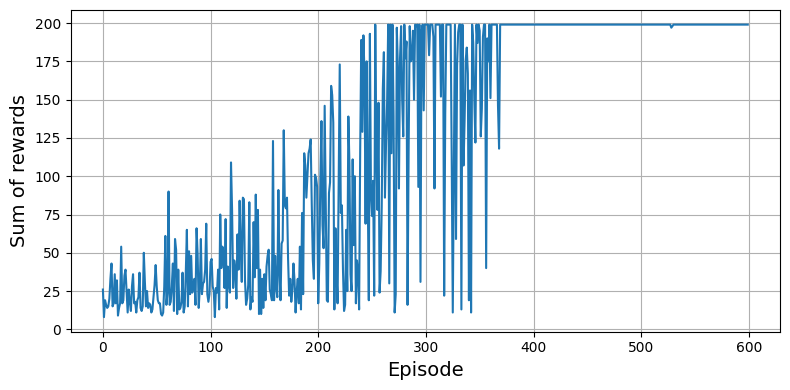

In [64]:
# extra code - this cell generates and saves Figure 18-10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
save_fig("dqn_rewards_plot")
plt.show()

# TESTING

## Test 1:

* *Observations:* 
    * The model seems to be finally working, went ahead and used the helper functions provided to help customize a model.

## Test 2:

* *Observations:* 
    * Need to have the model work a little more consistently. May need to either add some layers/mess with model OR implement other fine-tuning methods.

* *Changes:*
    * Adding layers to model. Added another dense layer before output:
    ...
        tf.keras.layers.Dense(32, activation="elu"),
    ...

* *Results:*
    * Not significant enough change to show improvement.

## Test 3:

* *Chagnes:* 
    * Restructuring the model to include normalization and dropout layers. Further adding layers as well.

    ...
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
        tf.keras.layers.Dense(32, activation="elu", kernel_regularizer=keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(32, activation="elu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(16, activation="elu"),
        tf.keras.layers.Dense(16, activation="elu"),
        tf.keras.layers.Dropout(rate=0.20),
        tf.keras.layers.Dense(n_outputs)
    ]) 
    ...


* *Results:*

* *Time:* 40 min

    * The model seems to have improved in some aspects. The range of improvement and sum of rewards is better. But it seems to take longer to get to that point. Maybe adding more episodes?

## Test 4:

* *Chagnes:*  
    * Removed a layer.

    ...
    tf.keras.layers.Dense(32, activation="elu"),
    ....

* *Results:*
    * This did not improve the metrics, adding layer back in.

* *Time:* 35 min
* *Episodes:* 600

## Test 5:

* *Chagnes:*  
    * Adjusted neuron count

     ...
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
        tf.keras.layers.Dense(32, activation="elu", kernel_regularizer=keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(16, activation="elu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(16, activation="elu"),
        tf.keras.layers.Dense(32, activation="elu"),
        tf.keras.layers.Dropout(rate=0.20),
        tf.keras.layers.Dense(n_outputs)
    ]) 
    ...

* *Results:*
    * This did not improve the metrics, changing neuron count back

* *Time:* 38 min
* *Episodes:* 600

## Test 6:

* *Issue:* Need to adjust some parameters to accomadate the number of episodes.

* *Results:*
    * This did not improve the metrics, changing episode count back. This also took FOREVER.


* *Time:* 1hr 2 min
* *Episodes:* 900


# TESTING RESULTS: Calling it a day, further adjustments can be made and tested when more time is provided.
